In [1]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import sklearn.metrics as sm
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix 

In [2]:
df = pd.read_csv('equipos.csv')

In [65]:
Xx = df.iloc[:, [4,5]]

In [66]:
X = Xx.fillna(0)

In [67]:
labels = df.iloc[:, 2].values

on essai de garder 90% de l'information 

In [22]:
pca = PCA(n_components = 0.9)

X contient des NaN et des valeurs trop grande pour dtype float64

In [23]:
X['total_cases'].isnull().values.any()

False

In [24]:
X['total_cases'].isnull().sum()

0

In [25]:
X['total_deaths'].isnull().sum()

0

In [26]:
X[X['total_deaths'].isna()]

,total_cases,total_deaths


In [27]:
pca.fit(X)

PCA(n_components=0.9)

In [28]:
print(pca.explained_variance_ratio_)

[0.99999147]


avec un seul axe on garde 99% de l'information

In [29]:
pca = PCA()
pca.fit(X)
ratio = pca.explained_variance_ratio_
ratio

array([9.99991469e-01, 8.53097762e-06])

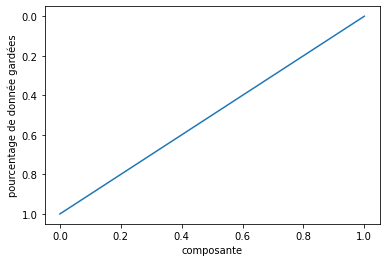

In [30]:
from matplotlib.pyplot import *
plt.plot(ratio)
plt.gca().invert_yaxis()
plt.xlabel('composante')
plt.ylabel('pourcentage de donnée gardées')
plt.show()

In [31]:
pca.components_

array([[ 0.99990609,  0.01370441],
       [-0.01370441,  0.99990609]])

In [64]:
X_pca = pca.transform(X)

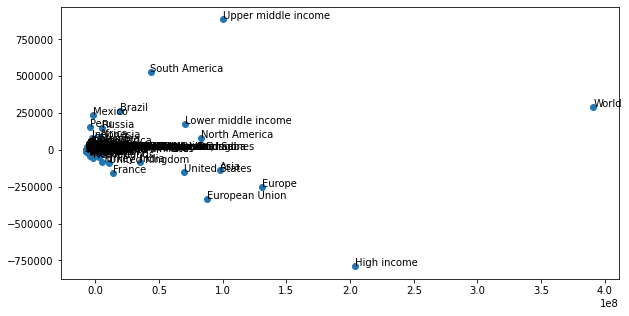

In [59]:
import matplotlib
plt.scatter(X_pca[:, 0], X_pca[:, 1])
for l, x, y in zip(labels, X_pca[:, 0], X_pca[:, 1]):
 plt.annotate(l, xy=(x, y), xytext=(-0.2, 0.2), textcoords='offset points')
plt.rcParams["figure.figsize"] = (10, 5)
plt.show()

la position des villes dépend des valeurs de pca.components_ et du poids associées

représentation des 2 composantes principales


Création de 6 clusters(regroupement des villes/continent ayant des caractéristiques similaires en nombre de cas/ nombre de décès) et représentation graphique de ces derniers

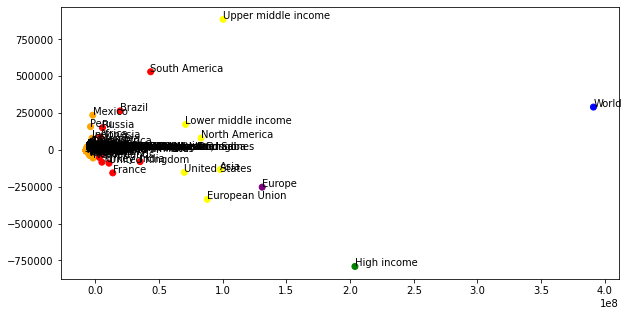

In [63]:
from sklearn.cluster import AgglomerativeClustering

colors=['red','yellow','blue','pink','green', 'orange', 'purple']

aggClustering = AgglomerativeClustering(linkage='ward', n_clusters=6).fit(X)
clustering_ward = aggClustering.labels_

plt.scatter(X_pca[:,0], X_pca[:,1], c=clustering_ward, cmap=matplotlib.colors.ListedColormap(colors))
for label,x,y in zip(labels, X_pca[:,0], X_pca[:,1]):
    plt.annotate(label, xy=(x,y), xytext=(-0.2,0.2), textcoords='offset points')
plt.show()

 - plus on est à gauche et en haut(en positif) -> pourcentage de mort élevé comparé au nombre de contaminé <br>
 - plus on est à gauche et en bas(en négatif) -> pourcentage de mort relativement bas comparé au nombre de cas de     covid
    - on peut s'apercevoir que les états unis ont un nombre de décès presque équivalent à celui de l'asie, meme si l'Asie a plus de contaminé que les états unis
 - plus on est à droite plus y'a de cas de covid
 - plus on monte plus y'a un nombre de décès important comparé au nombre de cas
 - plus on descend au négatif -> plus y'a de personnes guéris que de décès
 

In [68]:
import seaborn as sns; sns.set()

In [69]:
from sklearn.cluster import KMeans
X_acp = KMeans(n_clusters = 3)
X_acp.fit(X)
y_kmeans = X_acp.predict(X)

 - Création de cluster en utilisant la méthode KMeans C’est l’un des algorithmes de clustering les plus répandus. Il permet d’analyser un jeu de données caractérisées par un ensemble de descripteurs, afin de regrouper les données “similaires” en groupes (ou clusters). 

In [81]:
XY = X.values

In [88]:
new_label = df.iloc[:, 0].values

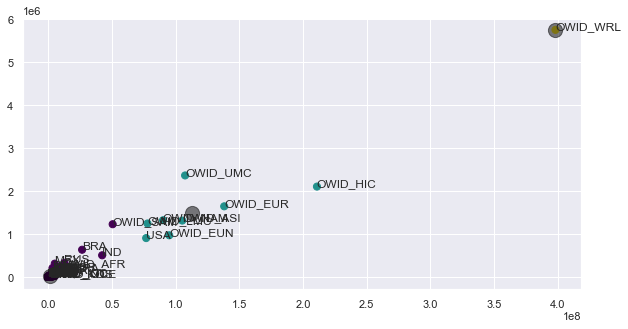

In [89]:
plt.scatter(XY[:, 0], XY[:, 1], c = y_kmeans, s = 50, cmap= 'viridis')
for label, x, y in zip(new_label, XY[:, 0], XY[:, 1]):
 plt.annotate(label, xy=(x, y), xytext=(-0.2, 0.2), textcoords='offset points')
centers = X_acp.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c = 'black', s=200, alpha= 0.5)

 - 3 clusters avec un point central pour
    - x => nombre de cas 
    - y => nombre de décès

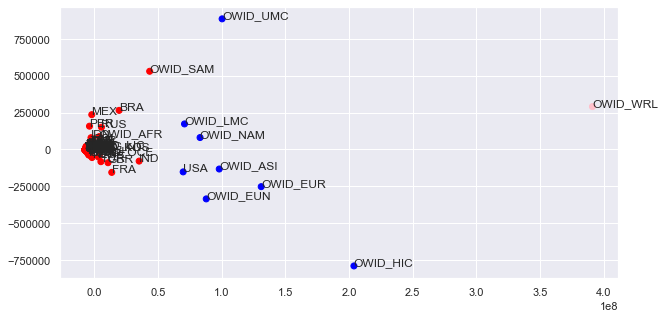

In [90]:
colors = ['red','yellow','blue','pink']
plt.scatter(X_pca[:, 0], X_pca[:, 1], c= y_kmeans, cmap=matplotlib.colors.ListedColormap(colors))
for label, x, y in zip(new_label, X_pca[:, 0], X_pca[:, 1]):
 plt.annotate(label, xy=(x, y), xytext=(-0.2, 0.2), textcoords='offset points')
plt.show()

In [99]:
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

SS = StandardScaler()
Xnorm = SS.fit_transform(X)
for i in range(2,7):
    model = KMeans(n_clusters=i)
    model.fit(Xnorm)
    print("avec", i, "classes:", round(metrics.silhouette_score(Xnorm, model.labels_, metric = 'euclidean'),2))

avec 2 classes: 0.95
avec 3 classes: 0.95
avec 4 classes: 0.94
avec 5 classes: 0.87
avec 6 classes: 0.86


 - L'indice silhouette est maximale avec 2 classes, donc utilisation de 2 cluster serait l'option optimal

In [93]:
def hybride(data, CAH_min=2, K_clusters=10):
    # data - array 2D correspondant aux valeurs du dataset,
    # CAH_min - nombre de clusters minimums souhaités (2 par défaut et 6 maximum)
    # K_clusters - nombre de clusters utilisés par K-Means / nombre de données d'entrée pour CAH
    if CAH_min > 6 :
        return "ERREUR - CAH_min supérieur à 6"

# Normalisation
    SS = StandardScaler()
    Xnorm = SS.fit_transform(data)
    
    
# Clustering temporaire par la méthode des K-Means
    modelTemp = KMeans(n_clusters=K_clusters, random_state=1)
    labelKmean = modelTemp.fit_predict(Xnorm)
    
    
# Récupération des barycentres
    centroids = modelTemp.cluster_centers_
    
    
# Clustering par la méthode CAH sur les barycentres

    # Optimisation de l'indice Silhouette
    maximum = 0;
    for crit in ('ward','average','single'):
        for n in range(CAH_min,7):
            model = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage=crit)
            model.fit(Xnorm)
            silhouette = metrics.silhouette_score(Xnorm, model.labels_, metric = 'euclidean')
            if silhouette > maximum:
                maximum = silhouette
                critOpti = crit
                classeOpti = n
    print(">>> CAH optimal pour le critère", critOpti, "sur", classeOpti, "classes:\n    Indice silhouette =",round(maximum,2))
    
    # Clustering optimal
    model = AgglomerativeClustering(n_clusters=classeOpti, affinity='euclidean', linkage=critOpti)
    labelCAH = model.fit_predict(centroids)
    
    
# Affectation des clusters finaux
    clustering = []
    for cluster in labelKmean:
        clustering.append(labelCAH[cluster])
        

# PCA
    pca = PCA(n_components=2)
    pca.fit(Xnorm)
    perte = round(100-np.sum(pca.explained_variance_ratio_)*100, 2)
    print("\n>>> Passage en 2 dimensions:\n    Perte d'information de", perte, "%")
    Xpca = pca.transform(Xnorm)


# Affichage
    colors = ['blue', 'magenta', 'lime', 'red', 'black', 'orange']
    plt.scatter(Xpca[:,0], Xpca[:,1], c=clustering, cmap=matplotlib.colors.ListedColormap(colors))
    for label, x, y in zip(labels, Xpca[:,0], Xpca[:,1]):
        plt.annotate(label, xy=(x,y), xytext=(-0.2,0.2), textcoords='offset points')
    return plt.show()

>>> CAH optimal pour le critère average sur 2 classes:
    Indice silhouette = 0.97

>>> Passage en 2 dimensions:
    Perte d'information de 0.0 %


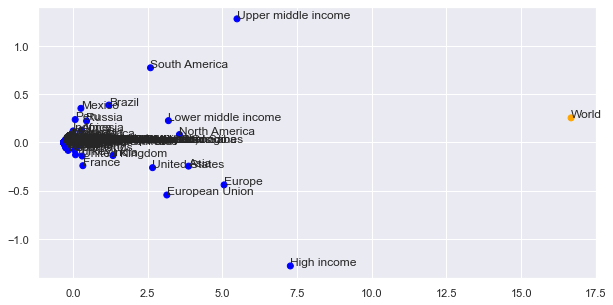

In [100]:
hybride(X)

In [119]:
df_rect = pd.read_csv('covid_pays.csv')

In [120]:
Yy = df.iloc[:, [4,5]]

In [121]:
Y = Xx.fillna(0)